# Mushroom Classification Using Different Classifiers (Course Project)

In this notebook, we explore the Secondary Mushroom dataset and build machine learning models to predict whether a mushroom is **edible** or **poisonous** from its observed characteristics (e.g., cap size/shape/color, gill properties, odor, habitat, and related attributes).

The dataset (`secondary_data.csv`, read using `;` as the separator) contains **61,069 samples** and **20 input features**, mostly categorical, with three continuous numerical variables: **cap-diameter**, **stem-height**, and **stem-width**. Using **Spark ML**, we preprocess the data (handle missing values and encode categorical features) and then train and compare three **tree-based classifiers**—**Decision Tree**, **Random Forest**, and **Gradient-Boosted Trees**—evaluating their performance on a held-out test set.


## 1. Importing the packages

In [4]:
# Spark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Spark ML: preprocessing
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, OneHotEncoderModel,  VectorAssembler, Imputer, StandardScaler
)
from pyspark.ml.stat import Correlation

# Spark ML: models (tree trio)
from pyspark.ml.classification import (
    DecisionTreeClassifier, DecisionTreeClassificationModel, RandomForestClassifier, GBTClassifier
)

# Spark ML: evaluation & tuning
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import os, urllib.request, zipfile
import numpy as np


## 2. Download and Read the CSV File

In this step, we start a Spark session, download the Secondary Mushroom Dataset from the UCI repository, and extract the nested ZIP files to access `secondary_data.csv`. Finally, we load the CSV into a **Spark DataFrame** using `;` as the separator (with header and automatic schema inference) and print the dataset size (rows and columns) to confirm the import was successful.


In [2]:
# Spark session
spark = SparkSession.builder.appName("MushroomClassification").getOrCreate()

In [61]:
# Download the outer zip
url = "https://archive.ics.uci.edu/static/public/848/secondary+mushroom+dataset.zip"
workdir = "/content/mushroom_data"
os.makedirs(workdir, exist_ok=True)

outer_zip = os.path.join(workdir, "secondary_mushroom_dataset.zip")
if not os.path.exists(outer_zip):
    urllib.request.urlretrieve(url, outer_zip)

# Unzip outer zip -> contains MushroomDataset.zip
outer_dir = os.path.join(workdir, "outer")
os.makedirs(outer_dir, exist_ok=True)
with zipfile.ZipFile(outer_zip, "r") as z:
    z.extractall(outer_dir)

inner_zip = os.path.join(outer_dir, "MushroomDataset.zip")

# Unzip inner zip -> contains MushroomDataset/secondary_data.csv
inner_dir = os.path.join(workdir, "inner")
os.makedirs(inner_dir, exist_ok=True)
with zipfile.ZipFile(inner_zip, "r") as z:
    z.extractall(inner_dir)

csv_path = os.path.join(inner_dir, "MushroomDataset", "secondary_data.csv")

# Read CSV into Spark DataFrame
df = spark.read.csv(
    csv_path,
    header=True,
    sep=";",
    inferSchema=True
)

In [5]:
# Size of dataset
print("Rows:", df.count(), " | Columns:", len(df.columns))

Rows: 61069  | Columns: 21


## 3. Examining and Manipulating the Data

In this section, I perform an initial exploration of the dataset using Spark DataFrame operations. I preview sample records with `.show()`, inspect column types with `.printSchema()`, and summarize the data with `.describe()` and `.summary()` (including approximate quantiles for the numeric features: cap-diameter, stem-height, and stem-width). These checks help validate the import, understand the structure of the data, and spot potential data-quality issues.

Next, I check for duplicate rows by comparing the total row count with the number of distinct rows, and then remove duplicates using `dropDuplicates()` to obtain a cleaner and more consistent dataset for the modeling stage.


In [6]:
df.show(10, truncate=False)

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|p    |15.26       |x        |g          |o        |f                   |e              |NULL        |w         |16.95      |17.09     |s        |y           |w         |u        |w         |t       |g        |NULL             |d      |w     |
|p    |16.6        |x   

In [7]:
df.printSchema()

root
 |-- class: string (nullable = true)
 |-- cap-diameter: double (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- does-bruise-or-bleed: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stem-height: double (nullable = true)
 |-- stem-width: double (nullable = true)
 |-- stem-root: string (nullable = true)
 |-- stem-surface: string (nullable = true)
 |-- stem-color: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- has-ring: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- habitat: string (nullable = true)
 |-- season: string (nullable = true)



In [8]:
df.describe().show()

+-------+-----+-----------------+---------+-----------+---------+--------------------+---------------+------------+----------+------------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|summary|class|     cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|       stem-height|        stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-------+-----+-----------------+---------+-----------+---------+--------------------+---------------+------------+----------+------------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|  count|61069|            61069|    61069|      46949|    61069|               61069|          51185|       36006|     61069|             61069|             61069|     9531|       229

In [9]:
# Summary statistics incl. approx quantiles for numeric columns
df.select("cap-diameter", "stem-height", "stem-width").summary().show()

+-------+-----------------+------------------+------------------+
|summary|     cap-diameter|       stem-height|        stem-width|
+-------+-----------------+------------------+------------------+
|  count|            61069|             61069|             61069|
|   mean|6.733854492459317| 6.581538260001019|12.149410011626177|
| stddev|5.264844947062989|3.3700168612896366| 10.03595504311756|
|    min|             0.38|               0.0|               0.0|
|    25%|             3.49|              4.64|              5.21|
|    50%|             5.86|              5.95|             10.19|
|    75%|             8.54|              7.74|             16.57|
|    max|            62.34|             33.92|            103.91|
+-------+-----------------+------------------+------------------+



In [10]:
# Number of duplicate rows (Spark)
n_total = df.count()
n_distinct = df.distinct().count()
n_dups = n_total - n_distinct
print(f"Number of duplicate rows before: {n_dups}")

Number of duplicate rows before: 146


In [11]:
# Drop duplicates
df_no_dups = df.dropDuplicates()

n_total_after = df_no_dups.count()
n_distinct_after = df_no_dups.distinct().count()
n_dups_after = n_total_after - n_distinct_after
print(f"Number of duplicate rows after: {n_dups_after}")

Number of duplicate rows after: 0


## 4. Class Distribution: Edible vs. Poisonous

In this section, I inspect the target column to confirm the available class labels and then compute the number of samples in each class using a Spark `groupBy` aggregation. Finally, we visualize the class counts with a bar chart to check whether the dataset is balanced (or skewed toward one class), which is important for interpreting metrics such as accuracy, precision/recall, and F1-score.


In [12]:
# Unique values
df_no_dups.select("class").distinct().show()

+-----+
|class|
+-----+
|    e|
|    p|
+-----+



In [13]:
# Value counts
class_counts_df = df_no_dups.groupBy("class").count()
class_counts_df.show()

+-----+-----+
|class|count|
+-----+-----+
|    e|27181|
|    p|33742|
+-----+-----+



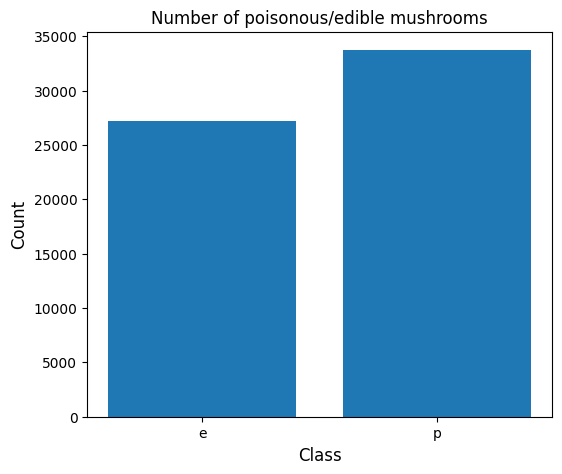

In [14]:
rows = class_counts_df.collect()
labels = [r["class"] for r in rows]
values = [r["count"] for r in rows]

plt.figure(figsize=(6, 5))
plt.bar(labels, values)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Class", fontsize=12)
plt.title("Number of poisonous/edible mushrooms")
plt.show()

## 5. Visualizing the Data

### 5.1. Preparing the Data for Visualization

In this step, I create a separate Spark DataFrame for visualization and add a numeric target column `label` by mapping the original classes (e → 0, p → 1) while keeping `class` for readability. We then split the predictors into the three continuous numeric features (cap-diameter, stem-height, stem-width) and the remaining categorical features.

To make the data suitable for plots, missing values in categorical columns are filled with an explicit `"missing"` category, and categorical variables are temporarily converted to numeric indices using `StringIndexer` (for visualization only). Finally, the numeric columns are assembled into a vector and standardized with `StandardScaler`, producing a scaled numeric vector (`num_scaled`) that makes distributions comparable across plots.


In [15]:
df_plot = df_no_dups

# target: map {"e": 0, "p": 1}
df_plot = df_plot.withColumn(
    "label",
    F.when(F.col("class") == "e", F.lit(0.0))
     .when(F.col("class") == "p", F.lit(1.0))
     .otherwise(F.lit(None).cast("double"))
)

# features
X_cols = [c for c in df_plot.columns if c not in ["class", "label"]]
num_cols = ["cap-diameter", "stem-height", "stem-width"]
cat_cols = [c for c in X_cols if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['cap-diameter', 'stem-height', 'stem-width']
Categorical: ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [16]:
# Fill nulls in categoricals to make "missing" explicit
df_enc = df_plot.na.fill({c: "missing" for c in cat_cols})

# "Ordinal encode" categoricals (Spark equivalent: StringIndexer -> index values)
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_cols
]

# Scale numeric columns (Spark StandardScaler works on a vector column)
num_assembler = VectorAssembler(inputCols=num_cols, outputCol="num_vec")
scaler = StandardScaler(inputCol="num_vec", outputCol="num_scaled", withMean=True, withStd=True)

# Build and run pipeline
pipe = Pipeline(stages=indexers + [num_assembler, scaler])
df_enc = pipe.fit(df_enc).transform(df_enc)

# Show a quick preview (similar to df_enc.head())
df_enc.select(["class", "label"] + [f"{c}_idx" for c in cat_cols] + ["num_scaled"]).show(5, truncate=False)

+-----+-----+-------------+---------------+-------------+------------------------+-------------------+----------------+--------------+-------------+----------------+--------------+-------------+--------------+------------+-------------+---------------------+-----------+----------+-----------------------------------------------------------+
|class|label|cap-shape_idx|cap-surface_idx|cap-color_idx|does-bruise-or-bleed_idx|gill-attachment_idx|gill-spacing_idx|gill-color_idx|stem-root_idx|stem-surface_idx|stem-color_idx|veil-type_idx|veil-color_idx|has-ring_idx|ring-type_idx|spore-print-color_idx|habitat_idx|season_idx|num_scaled                                                 |
+-----+-----+-------------+---------------+-------------+------------------------+-------------------+----------------+--------------+-------------+----------------+--------------+-------------+--------------+------------+-------------+---------------------+-----------+----------+-----------------------------------

### 5.2. Box Plot (Numeric Features vs. Class)

In this section, I use box plots to compare how the three continuous numeric features vary between edible (e) and poisonous (p) mushrooms. Because Spark DataFrames are not plotted directly with matplotlib/seaborn, I first select only the required columns, drop rows with missing numeric values, and then take a random sample (with an upper limit) to keep plotting fast in Colab. The resulting sample is converted to a small pandas DataFrame purely for visualization. Box plots are shown only for **cap-diameter**, **stem-height**, and **stem-width**, since all other variables in this dataset are categorical.


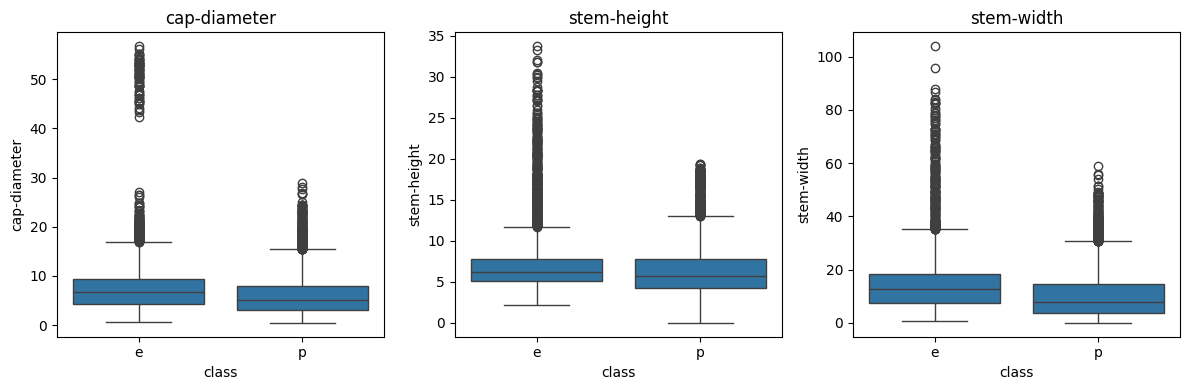

In [17]:
num_cols = ["cap-diameter", "stem-height", "stem-width"]

# Take a manageable sample to plot (adjust fraction/limit as you like)
plot_sdf = df_no_dups.select(["class"] + num_cols).dropna(subset=num_cols)

# random sample + hard cap
plot_pdf = (plot_sdf
            .sample(withReplacement=False, fraction=0.2, seed=42)
            .limit(20000)
            .toPandas())

# Plotting
plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=plot_pdf, x="class", y=col)
    plt.title(col)

plt.tight_layout()
plt.show()

**!Conclusion**:
Edible mushrooms show slightly higher median size (cap diameter, stem height, stem width), but the distributions overlap heavily, so these numeric features alone don’t separate the classes well. All three variables also contain many outliers, indicating high variation in size.

#### 5.3. Correlation Heatmap (Label vs. Numeric Features)

In this step, we compute a correlation heatmap to quickly examine linear relationships between the target label and the three continuous numeric variables (cap-diameter, stem-height, stem-width). The correlation matrix is calculated directly in Spark using `VectorAssembler` and `Correlation.corr`, then visualized as a heatmap (absolute values scaled to 0–1) for easier interpretation. Since most dataset attributes are categorical, the correlation analysis is limited to these numeric features.


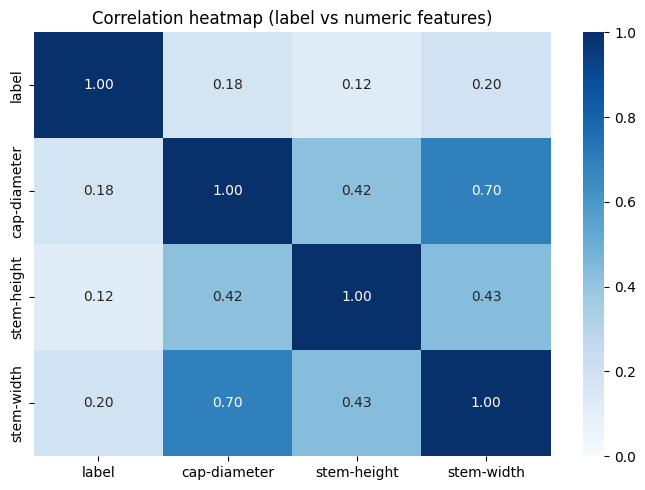

In [18]:
# Build the list of columns to include in the correlation matrix
num_cols = ["cap-diameter", "stem-height", "stem-width"]
cols_for_corr = ["label"] + num_cols

df_corr = df_plot.select(cols_for_corr).dropna()

vec = VectorAssembler(inputCols=cols_for_corr, outputCol="features").transform(df_corr).select("features")
corr_np = Correlation.corr(vec, "features").head()[0].toArray()

# Plot (abs scaled 0..1 like your original)
plt.figure(figsize=(7, 5))
sns.heatmap(
    np.abs(corr_np),
    cmap="Blues",
    vmin=0, vmax=1,
    annot=True, fmt=".2f",
    xticklabels=cols_for_corr,
    yticklabels=cols_for_corr
)
plt.title("Correlation heatmap (label vs numeric features)")
plt.tight_layout()
plt.show()


**!Conclusion:**
The label has only weak linear correlations with each numeric feature (about 0.12–0.20), so none of the size measurements alone explains edibility well. In contrast, the numeric features are more strongly related to each other—especially cap-diameter vs. stem-width (~0.70)—suggesting some redundancy among size variables. Overall, this supports the idea that accurate classification likely depends on combining multiple attributes (especially the categorical ones), rather than relying on a single numeric measurement.

#### 5.4. Categorical Association Heatmap (Cramér’s V)

Since most attributes in this dataset are categorical, Pearson correlation is not appropriate. Instead, we use **Cramér’s V**, a chi-square–based measure of association between two categorical variables that ranges from **0** (no association) to **1** (strong association). Here, we compute Cramér’s V between each selected categorical feature and the target label to identify which attributes are most related to mushroom edibility.

To avoid dropping records during the contingency-table computation, we replace `?` and null values with an explicit `"missing"` category for this analysis. We focus on **feature vs. label** (rather than all pairwise feature–feature associations) because a full Cramér’s V matrix requires computing contingency tables for every feature pair, which is significantly more expensive and can become hard to read; for modeling, the most informative first step is understanding which features are directly associated with the target.


In [19]:
def cramers_v(df, col_x: str, col_y: str, fill_value: str = "missing") -> float:
    """
    Bias-corrected Cramér's V (0..1) for two categorical columns in a Spark DataFrame.

    Parameters
    ----------
    df : pyspark.sql.DataFrame
        Input Spark DataFrame.
    col_x, col_y : str
        Names of the categorical columns.
    fill_value : str
        Value used to fill nulls in the two columns before computing the table.

    Returns
    -------
    float
        Bias-corrected Cramér's V in [0, 1].
    """

    # Fill nulls (like pandas fillna("missing"))
    sdf = df.select(col_x, col_y).na.fill({col_x: fill_value, col_y: fill_value})

    # Build contingency table in Spark: rows = col_x, columns = col_y
    #   This produces columns: [col_x, <y_cat1>, <y_cat2>, ...]
    ct = (
        sdf.groupBy(col_x, col_y)
           .count()
           .groupBy(col_x)
           .pivot(col_y)
           .sum("count")
           .na.fill(0)
    )

    # Collect the contingency table to driver (small aggregated table)
    pdf = ct.toPandas()
    if pdf.shape[0] == 0:
        return 0.0

    # Keep only the y-category count columns (exclude the row key col_x)
    y_cols = [c for c in pdf.columns if c != col_x]
    counts = pdf[y_cols].to_numpy(dtype=float)

    n = counts.sum()
    if n <= 1:
        return 0.0

    # Compute chi-square from counts (no SciPy needed)
    row_sums = counts.sum(axis=1, keepdims=True)
    col_sums = counts.sum(axis=0, keepdims=True)
    expected = row_sums @ col_sums / n

    mask = expected > 0
    chi2 = ((counts - expected) ** 2 / expected)[mask].sum()

    # Bias-corrected Cramér’s V (same formula as your pandas version)
    r, k = counts.shape
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)

    denom = min(kcorr - 1, rcorr - 1)
    return float(np.sqrt(phi2corr / denom)) if denom > 0 else 0.0


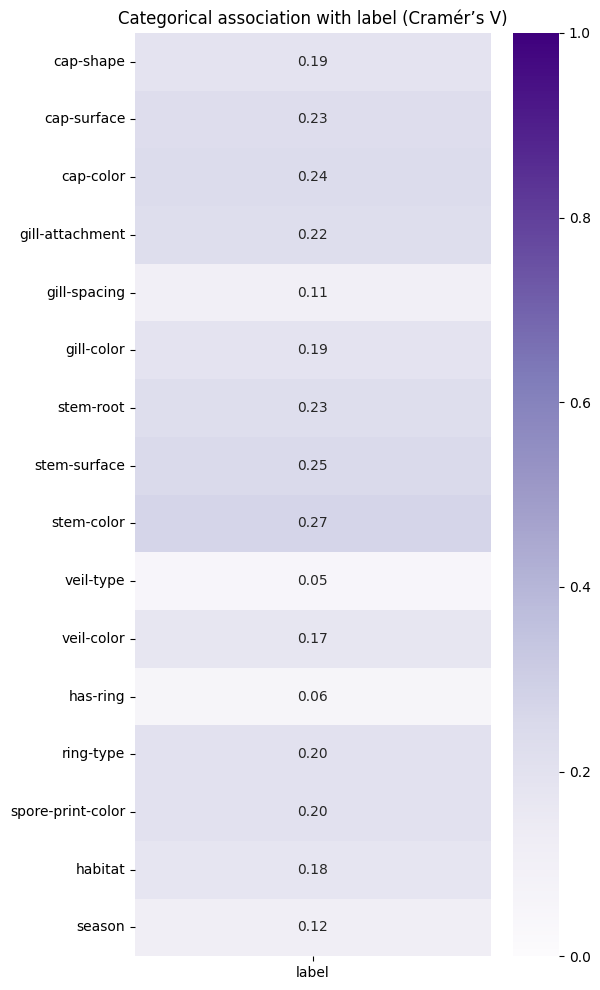

In [62]:
# Choose the subset of categorical columns (same as your list) ---
subset = ["cap-shape", "cap-surface", "cap-color",
          "gill-attachment", "gill-spacing", "gill-color",
          "stem-root", "stem-surface", "stem-color",
          "veil-type", "veil-color",
          "has-ring", "ring-type",
          "spore-print-color", "habitat", "season"]

# Keep only columns that actually exist in your Spark DF
subset = [c for c in subset if c in df_no_dups.columns]

# Prepare Spark DF: select subset + label, replace "?" with null, fill nulls with "missing" ---
df_cat = df_plot.select(subset + ["label"])

# Replace "?" with null on categoricals (Spark equivalent of df.replace("?", np.nan))
for c in subset:
    df_cat = df_cat.withColumn(c, F.when(F.col(c) == "?", F.lit(None)).otherwise(F.col(c)))

# Fill missing categoricals with "missing"
df_cat = df_cat.na.fill({c: "missing" for c in subset})

# Treat label as categorical for Cramér's V (0/1 -> "0"/"1")
df_cat = df_cat.withColumn("label_cat", F.col("label").cast("string"))

# Compute Cramér’s V: each feature vs label ---
results = []
for c in subset:
    v = cramers_v(df_cat, c, "label_cat")
    results.append((c, v))

# Plot without pandas: build a (n_features x 1) matrix ---
features = [r[0] for r in results]
vals = np.array([r[1] for r in results], dtype=float).reshape(-1, 1)

plt.figure(figsize=(6, 10))
sns.heatmap(vals, annot=True, fmt=".2f", cmap="Purples", vmin=0, vmax=1,
            yticklabels=features, xticklabels=["label"])
plt.title("Categorical association with label (Cramér’s V)")
plt.tight_layout()
plt.show()


**!Conclusion:**
The Cramér’s V analysis shows that individual categorical attributes have weak to moderate associations with the target label (roughly 0.05–0.27), indicating that no single categorical feature is sufficient to explain edibility on its own. Among the evaluated variables, stem-color (≈0.27), stem-surface (≈0.25), cap-color (≈0.24), and stem-root / cap-surface (≈0.23) exhibit the strongest relationships with the label, making them promising predictors. In contrast, veil-type (≈0.05) and has-ring (≈0.06) show very weak association and are likely less informative in isolation. Overall, these results suggest that accurate classification will rely on combining multiple categorical cues, rather than depending on any single attribute.

## 6. Data Preprocessing and Train/Test Split

In this section, I prepare the dataset for Spark ML modeling. First, I create a numeric target column `label` by mapping the original classes (e → 0, p → 1). I then identify the three continuous numeric features (cap-diameter, stem-height, stem-width) and treat all remaining columns as categorical. To standardize missing-value handling, I convert `"?"` entries in categorical columns to null and fill missing categories with an explicit `"missing"` value.

Next, I split the data into training and test sets using Spark’s `randomSplit` (80/20). Finally, I build a preprocessing pipeline that produces a single feature vector required by Spark ML: numeric columns are imputed with the median, categorical columns are indexed (`StringIndexer`) and one-hot encoded (`OneHotEncoder`), and all processed features are combined into a `features` vector using `VectorAssembler`. The pipeline is fit on the training set only and then applied to both splits to create model-ready DataFrames (`train_ready`, `test_ready`).


In [21]:
# Define numeric & categorical columns ----------
num_cols = ["cap-diameter", "stem-height", "stem-width"]
all_cols = df_no_dups.columns

# Features = all except target columns
feature_cols = [c for c in all_cols if c != "class"]

cat_cols = [c for c in feature_cols if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", len(cat_cols))

Numeric: ['cap-diameter', 'stem-height', 'stem-width']
Categorical: 17


In [69]:
# Create label + clean categoricals
df_prep = df_no_dups

# label: e->0, p->1
df_prep = df_prep.withColumn(
    "label",
    F.when(F.col("class") == "e", F.lit(0.0))
     .when(F.col("class") == "p", F.lit(1.0))
     .otherwise(F.lit(None).cast("double"))
)

# Replace "?" with null in categorical columns
for c in cat_cols:
    df_prep = df_prep.withColumn(c, F.when(F.col(c) == "?", F.lit(None)).otherwise(F.col(c)))

# Fill missing categoricals with "missing"
df_prep = df_prep.na.fill({c: "missing" for c in cat_cols})

# drop rows where label is null
df_prep = df_prep.dropna(subset=["label"])

print("Rows after cleaning:", df_prep.count())
print("Columns:", len(df_prep.columns))

Rows after cleaning: 60923
Columns: 22


In [23]:
# Train/Test split
# Spark doesn't do stratified split out of the box; randomSplit is standard in Spark projects.
train_df, test_df = df_prep.randomSplit([0.8, 0.2], seed=42)

print("Train rows:", train_df.count())
print("Test rows:", test_df.count())

Train rows: 48927
Test rows: 11996


In [24]:
# Preprocessing pipeline (tree-based friendly)
# Numeric: median imputation (no scaling needed for trees)
imputer = Imputer(
    inputCols=num_cols,
    outputCols=[f"{c}_imp" for c in num_cols]
).setStrategy("median")

num_imp_cols = [f"{c}_imp" for c in num_cols]

# Categorical: StringIndexer -> OneHotEncoder
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
idx_cols = [f"{c}_idx" for c in cat_cols]

encoder = OneHotEncoder(
    inputCols=idx_cols,
    outputCols=[f"{c}_ohe" for c in cat_cols],
    handleInvalid="keep"
)
ohe_cols = [f"{c}_ohe" for c in cat_cols]

# Assemble final feature vector
assembler = VectorAssembler(inputCols=num_imp_cols + ohe_cols, outputCol="features")

# Full preprocessing pipeline (model will be added later)
prep_pipeline = Pipeline(stages=[imputer] + indexers + [encoder, assembler])

In [25]:
# Fit on train only, then transform train & test
prep_model = prep_pipeline.fit(train_df)
train_ready = prep_model.transform(train_df).select("label", "features")
test_ready  = prep_model.transform(test_df).select("label", "features")

# Just to check: number of features in the vector
n_features = train_ready.first()["features"].size
print("Train ready rows:", train_ready.count())
print("Test ready rows:", test_ready.count())
print("Number of assembled features:", n_features)

Train ready rows: 48927
Test ready rows: 11996
Number of assembled features: 145


## 7. Helper Functions

To keep the notebook clean and avoid repeating code across models, I define a set of reusable helper functions used throughout the training and evaluation steps.

- `base_feature_name()` maps engineered pipeline column names (e.g., imputed or one-hot encoded columns) back to their original feature names so results can be interpreted at the feature level.

- `tree_feature_importance()` extracts feature importances from a fitted Spark tree model (Decision Tree / Random Forest / Gradient-Boosted Trees), then aggregates one-hot encoded dimensions back to the original categorical feature and reports the results both as a table and a horizontal bar plot.

- `plot_confusion_matrix()` computes the confusion matrix directly from Spark predictions, prints key classification metrics (accuracy, F1-score, precision, recall), and visualizes the confusion matrix as a heatmap for an intuitive overview of prediction errors.

- `print_all_models_table()` prints a compact, formatted comparison table for all trained models (e.g., LR, Linear SVM, Naive Bayes), reporting key test metrics such as **accuracy** and **F1-score** in a consistent layout for the final results section.

In [26]:
# Map pipeline column name back to original feature name
def base_feature_name(col_name: str) -> str:
  if col_name.endswith("_imp"):
      return col_name[:-4]  # remove "_imp"
  if col_name.endswith("_ohe"):
      return col_name[:-4]  # remove "_ohe"
  if col_name.endswith("_idx"):
      return col_name[:-4]  # remove "_idx" (if ever assembled directly)
  return col_name


In [27]:
# A helper function for plotting the feature importances of the models
def tree_feature_importance(
    fitted_pipeline_model,
    features_col: str = "features",
    top_m: int = 20,
    plot: bool = True,
    title: str = "Feature Importances",
    print_table: bool = True
):
    """
    Extract and aggregate feature importances from a fitted Spark PipelineModel
    that ends with a tree-based classifier (DT/RF/GBT) and uses OHE + VectorAssembler.

    Returns
    -------
    items : list[tuple[str, float]]
        Sorted list of (feature_name, importance_percent).
    """

    stages = fitted_pipeline_model.stages
    if not stages:
        raise ValueError("PipelineModel has no stages.")

    # 1) Get the trained tree model (last stage) and its importances
    model_stage = stages[-1]
    if not hasattr(model_stage, "featureImportances"):
        raise ValueError("Last stage does not expose featureImportances (not a tree model?).")

    importances = model_stage.featureImportances.toArray()

    # 2) Find the assembler that created the features vector
    assembler_model = None
    for s in stages:
        if isinstance(s, VectorAssembler) and s.getOutputCol() == features_col:
            assembler_model = s
            break
    if assembler_model is None:
        raise ValueError(f"Could not find VectorAssembler with outputCol='{features_col}' in pipeline stages.")

    assembler_inputs = assembler_model.getInputCols()

    # 3) Find fitted OneHotEncoderModel if present (to know vector sizes)
    encoder_model = None
    for s in stages:
        if isinstance(s, OneHotEncoderModel):
            encoder_model = s
            break

    ohe_size_map = {}
    if encoder_model is not None:
        ohe_out_cols = list(encoder_model.getOutputCols())
        ohe_sizes = list(encoder_model.categorySizes)  # aligned with out cols
        ohe_size_map = dict(zip(ohe_out_cols, map(int, ohe_sizes)))

    # 5) Walk through the assembled inputs and aggregate importance by base feature
    agg = {}
    idx = 0

    for col in assembler_inputs:
        base = base_feature_name(col)

        # Numeric/imputed columns are scalar (size 1)
        if col.endswith("_imp"):
            size = 1

        # OneHotEncoder output columns are vector blocks (size known from encoder model)
        elif col in ohe_size_map:
            size = ohe_size_map[col]

        # Fallback: treat as scalar
        else:
            size = 1

        block = importances[idx: idx + size] if size > 0 else np.array([])
        agg[base] = agg.get(base, 0.0) + float(block.sum()) if block.size else agg.get(base, 0.0)
        idx += size

    # 6) Convert to percentages and sort
    total = sum(agg.values()) if agg else 0.0
    items = [(k, (v / total * 100.0) if total > 0 else 0.0) for k, v in agg.items()]
    items.sort(key=lambda x: x[1], reverse=True)

    # 6) Print table (top_m)
    if print_table:
        top = items[:top_m]
        name_w = max(len("Feature"), max((len(f) for f, _ in top), default=0))
        print(f"\n{title}")
        print(f"{'Feature':<{name_w}}  {'Importance (%)':>14}")
        print("-" * (name_w + 2 + 14))
        for feat, pct in top:
            print(f"{feat:<{name_w}}  {pct:>14.2f}")

    print("")
    # 7) Plot top_m
    if plot:
        top = items[:top_m]
        feats = [f for f, _ in top][::-1]
        vals = [v for _, v in top][::-1]

        plt.figure(figsize=(8, 5))
        plt.barh(feats, vals)
        plt.title(title)
        plt.xlabel("importance (%)")
        plt.tight_layout()
        plt.show()

    return items


In [28]:
def plot_confusion_matrix(
    pred_df,
    title="Confusion Matrix",
    label_col="label",
    pred_col="prediction",
    class_names=("edible", "poisonous"),
    positive_label=1.0,
    show_metrics=True
):
    # Keep only needed cols and cast to double for consistency
    df = pred_df.select(
        F.col(label_col).cast("double").alias("label"),
        F.col(pred_col).cast("double").alias("prediction")
    )

    #  Compute confusion counts robustly (no pivot / no key mismatch)
    tp = df.filter((F.col("label") == positive_label) & (F.col("prediction") == positive_label)).count()
    tn = df.filter((F.col("label") != positive_label) & (F.col("prediction") != positive_label)).count()
    fp = df.filter((F.col("label") != positive_label) & (F.col("prediction") == positive_label)).count()
    fn = df.filter((F.col("label") == positive_label) & (F.col("prediction") != positive_label)).count()

    cm = np.array([[tn, fp],
                   [fn, tp]], dtype=int)

    #  Metrics
    if show_metrics:
        acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        f1_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

        acc = acc_eval.evaluate(df)
        f1  = f1_eval.evaluate(df)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        print(f"Accuracy : {acc*100:.3f}%")
        print(f"F1-score  : {f1:.5f}")
        print(f"Precision : {precision:.5f}")
        print(f"Recall    : {recall:.5f}\n")

    #  Plotting
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=list(class_names),
        yticklabels=list(class_names)
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return cm


In [71]:
def print_all_models_table(all_models):
    model_w = max(len(r["model"]) for r in all_models + [{"model":"Model"}])
    acc_w = len("Test Accuracy (%)")
    f1_w = len("Test F1")

    header = f"{'Model':<{model_w}}  {'Test Accuracy (%)':>{acc_w}}  {'Test F1':>{f1_w}}"
    print(header)
    print("-" * len(header))

    for r in all_models:
        print(f"{r['model']:<{model_w}}  {r['test_acc']:>{acc_w}.3f}  {r['test_f1']:>{f1_w}.5f}")

## 8. Classification Methods

In this section, we train and compare three **tree-based** classifiers—**Decision Tree (DT)**, **Random Forest (RF)**, and **Gradient-Boosted Trees (GBT)**—to predict whether a mushroom is edible or poisonous. All models are trained and evaluated using the same preprocessing pipeline and the same train/test split to ensure a fair comparison. We report standard classification metrics and summarize the results to identify the most effective tree-based approach for this dataset.


In [29]:
# Store model results for later comparison
all_models = []

### 8.1. Decision Tree Classifier

#### 8.1.1. Training the Decision Tree Pipeline

In this step, I build a Spark ML `Pipeline` that combines the preprocessing stages with a **Decision Tree** classifier. Training the pipeline on the training split ensures that all preprocessing steps (imputation, indexing, one-hot encoding, and feature assembly) are learned from the training data only and then applied consistently when generating predictions on the test set. The tree depth is controlled using `maxDepth` to limit model complexity.

In [32]:
# Decision Tree classifier
dt = DecisionTreeClassifier(
  labelCol="label",
  featuresCol="features",
  seed=42,
  maxDepth= 20
)

# Full pipeline: preprocessing + model
dt_model = Pipeline(stages=prep_pipeline.getStages() + [dt])

# Fit on training DataFrame
dt_fitted = dt_model.fit(train_df)

#### 8.1.2. Feature Importance

After training the Decision Tree, we examine its **feature importances** to understand which inputs most influence the model’s decisions. Because categorical variables are one-hot encoded into multiple dimensions, we aggregate the importance scores back to their original feature names (summing the contributions of all one-hot components). Finally, we display and plot the top 20 features to highlight the most influential attributes in the tree-based prediction.



Decision Tree Feature Importances
Feature               Importance (%)
------------------------------------
cap-surface                    14.90
stem-width                     12.64
stem-surface                    9.15
stem-color                      8.94
gill-color                      7.99
gill-spacing                    6.18
stem-root                       6.14
gill-attachment                 6.01
cap-shape                       5.35
stem-height                     4.59
cap-color                       3.81
ring-type                       3.76
does-bruise-or-bleed            2.31
cap-diameter                    1.98
has-ring                        1.79
veil-color                      1.63
habitat                         1.27
spore-print-color               0.84
season                          0.73
veil-type                       0.00



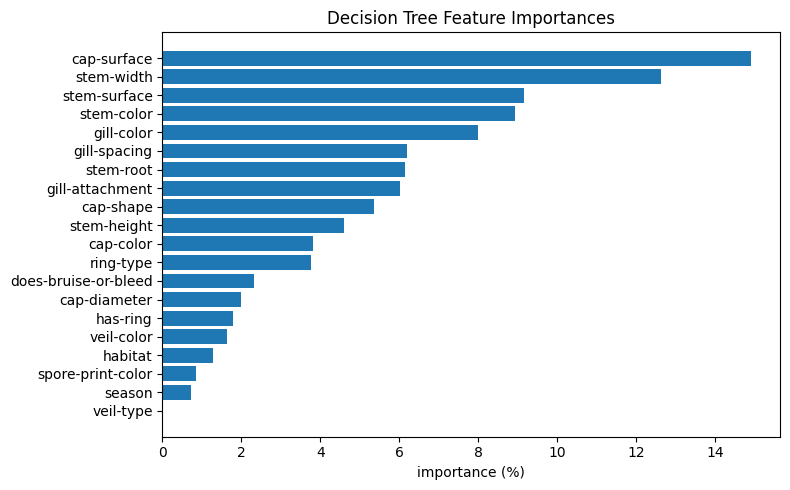

In [33]:
dt_items = tree_feature_importance(dt_fitted, top_m=20, plot=True, title="Decision Tree Feature Importances")

**!Conclusion:**
The Decision Tree relies most on a small set of attributes, with cap-surface and stem-width contributing the largest share, followed by stem-surface, stem-color, and key gill-related features. Several variables (e.g., veil-type) have little to no impact in this model, suggesting they are not used in the tree’s main splits for this train/test setup.

#### 8.1.3. Predicting on the Test Set

After fitting the Decision Tree pipeline, we generate predictions on the held-out test set using `transform()`. Model performance is then evaluated with Spark’s built-in evaluators, reporting **accuracy** and **F1-score**. We also print the trained tree’s `maxDepth` to document the final model complexity used for this run.

For a quick overfitting check, I also compute the **training accuracy** using the same evaluator and compare it with the test result.


In [34]:
# Predict on held-out test set
dt_pred = dt_fitted.transform(test_df)

# Core metrics (Spark evaluators)
acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

acc_dt = acc_eval.evaluate(dt_pred)
f1_dt  = f1_eval.evaluate(dt_pred)

tree_model = dt_fitted.stages[-1]

print(f"maxDepth: {tree_model.getMaxDepth()}")
print(f"Accuracy : {acc_dt * 100:.3f}%")
print(f"F1-score  : {f1_dt:.5f}")

maxDepth: 20
Accuracy : 99.792%
F1-score  : 0.99792


In [73]:
dt_pred_train = dt_fitted.transform(train_df)
acc_dt_train = acc_eval.evaluate(dt_pred_train)
print(f"Train accuracy: {round(acc_dt_train * 100, 3)}%")

Train accuracy: 99.859%


**!Conclusion:**
The Decision Tree delivers near-perfect performance (≈99.79% test accuracy, F1 ≈0.998). The training accuracy is only slightly higher than the test accuracy, indicating strong generalization with minimal overfitting at maxDepth = 20.

#### 8.1.4. Confusion Matrix

To complement the numeric metrics, we visualize the Decision Tree’s performance using a **confusion matrix**. This plot summarizes correct and incorrect predictions for each class (edible vs. poisonous), making it easier to see whether errors are concentrated in false positives or false negatives rather than relying only on overall accuracy.


Accuracy : 99.792%
F1-score  : 0.99792
Precision : 0.99940
Recall    : 0.99685



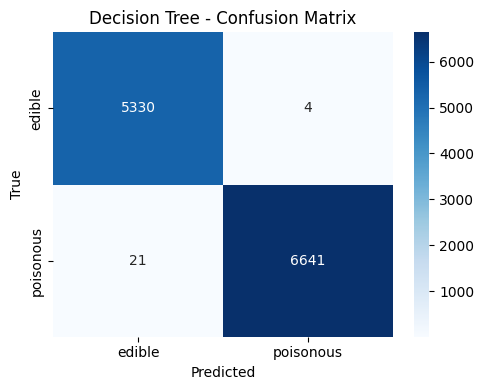

In [36]:
cm = plot_confusion_matrix(dt_pred, title="Decision Tree - Confusion Matrix")

**!Conclusion:**
The Decision Tree performs extremely well on the test set, with near-perfect accuracy and F1-score. The confusion matrix shows only a handful of errors, indicating strong separation between edible and poisonous mushrooms for this split.

In [37]:
# Adding the Decision Tree Results to the all_models list
dt_results = {"model": "Decision Tree", "test_acc": round(acc_dt * 100, 3), "test_f1": round(f1_dt, 5)}
all_models.append(dt_results)

In [38]:
all_models

[{'model': 'Decision Tree', 'test_acc': 99.792, 'test_f1': 0.99792}]

### 8.2. Random Forest Classifier

#### 8.2.1. Training the Random Forest Pipeline

In this step, we train a **Random Forest** classifier using the same preprocessing pipeline to ensure consistent treatment of missing values and categorical variables. A Random Forest is an ensemble of decision trees built on different bootstrap samples and feature subsets, which typically improves robustness and reduces overfitting compared to a single tree. Here, we configure the forest with a fixed number of trees (`numTrees`) and control model complexity using `maxDepth`.


In [39]:
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    seed=42,
    numTrees=300,
    maxDepth= 12
)

rf_model = Pipeline(stages=prep_pipeline.getStages() + [rf])

rf_fitted = rf_model.fit(train_df)

#### 8.2.2. Feature Importance

After training the Random Forest, I analyze its **feature importances** to identify which variables are most influential in the ensemble’s decisions. Because categorical features are one-hot encoded into multiple dimensions, I aggregate the importance scores back to the original feature names by summing the contributions of all encoded components. Finally, I report and plot the top 20 features to highlight the strongest predictors.


Random Forest Feature Importances
Feature               Importance (%)
------------------------------------
cap-surface                    10.15
gill-attachment                 9.48
stem-color                      8.06
stem-surface                    7.74
gill-color                      7.38
stem-width                      7.20
gill-spacing                    6.32
stem-root                       5.69
cap-color                       5.43
cap-shape                       5.09
ring-type                       4.90
stem-height                     4.57
cap-diameter                    4.53
habitat                         2.50
spore-print-color               2.42
does-bruise-or-bleed            2.38
has-ring                        2.07
veil-color                      1.93
season                          1.23
veil-type                       0.95



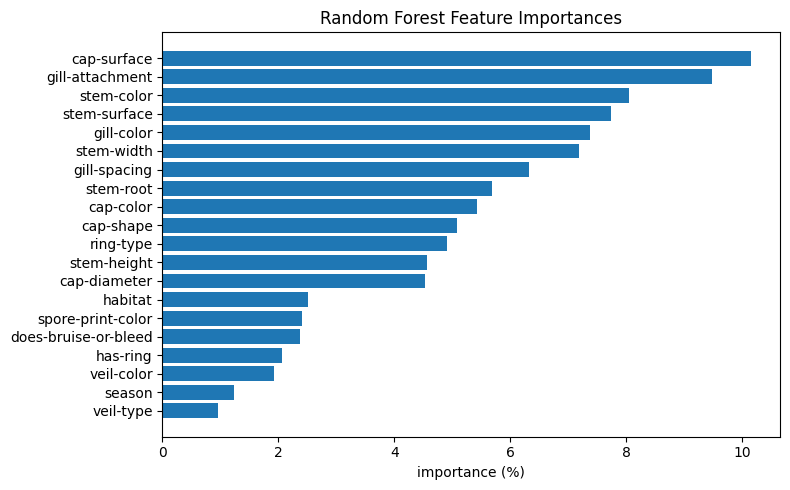

In [40]:
rf_items = tree_feature_importance(rf_fitted, top_m=20, plot=True, title="Random Forest Feature Importances")

**!Conclusion:** The Random Forest spreads importance across several features rather than relying on a single split, with cap-surface, gill-attachment, and stem-color/surface among the strongest predictors. Overall, gill- and stem-related attributes dominate, while features like veil-type and season contribute relatively little.


#### 8.2.3. Predicting on the Test Set

After fitting the Random Forest pipeline, I generate predictions on the held-out test set using `transform()`. I then evaluate performance with Spark’s evaluators, reporting **test accuracy** and **F1-score**, and I print the model’s `maxDepth` to document the final complexity.

For a quick overfitting check, I also compute the **training accuracy** using the same evaluator and compare it with the test result.


In [41]:
# Predict on held-out test set (Spark)
rf_pred = rf_fitted.transform(test_df)

#  Core metrics (Spark evaluators) ---
acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

acc_rf = acc_eval.evaluate(rf_pred)
f1_rf  = f1_eval.evaluate(rf_pred)

tree_model = rf_fitted.stages[-1]

print(f"maxDepth: {tree_model.getMaxDepth()}")
print(f"Test Accuracy : {acc_rf * 100:.3f}%")
print(f"Test F1-score  : {f1_rf:.5f}")

maxDepth: 12
Test Accuracy : 99.250%
Test F1-score  : 0.99250


In [42]:
rf_pred_train = rf_fitted.transform(train_df)
acc_rf_train = acc_eval.evaluate(rf_pred_train)
print(f"Train accuracy: {round(acc_rf_train * 100, 3)}%")

Train accuracy: 99.133%


**!Conclusion:**
The Random Forest achieves very strong performance on the test set (≈99.25% accuracy, F1 ≈0.993). The training and test accuracies are close, suggesting good generalization with no clear signs of overfitting at maxDepth = 12.

#### 8.2.4. Confusion Matrix

To complement the evaluation metrics, I plot the **confusion matrix** for the Random Forest predictions. This visualization breaks down the number of correct classifications and the types of errors (false positives and false negatives) for edible vs. poisonous mushrooms, providing a clearer view of model behavior than accuracy alone.


Accuracy : 99.250%
F1-score  : 0.99250
Precision : 0.99414
Recall    : 0.99234



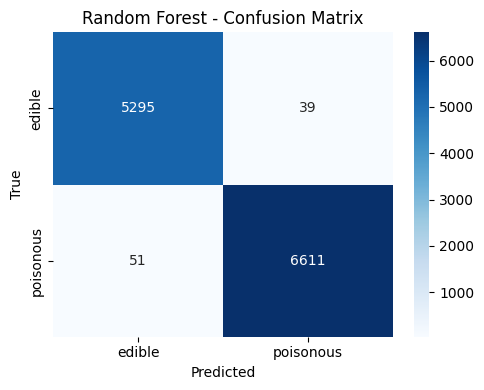

In [43]:
rf_cm = plot_confusion_matrix(rf_pred, title="Random Forest - Confusion Matrix")

**!Conclusion:**
The Random Forest performs very well, with high accuracy and F1-score. The confusion matrix shows only a small number of mistakes in both directions (false positives and false negatives), indicating strong and well-balanced classification between edible and poisonous mushrooms.

In [44]:
# Adding the Random Forest Results to the all_models list
rf_results = {"model": 'Random Forest', "test_acc": round(acc_rf * 100, 3), "test_f1": round(f1_rf, 5)}
all_models.append(rf_results)

In [45]:
all_models

[{'model': 'Decision Tree', 'test_acc': 99.792, 'test_f1': 0.99792},
 {'model': 'Random Forest', 'test_acc': 99.25, 'test_f1': 0.9925}]

### 8.3. Gradient-Boosted Trees Classifier

#### 8.3.1. Training the Gradient-Boosted Trees Pipeline

In this step, I train a **Gradient-Boosted Trees (GBT)** classifier using the same preprocessing pipeline to keep feature handling consistent across models. Unlike Random Forest (which trains trees independently), GBT builds trees **sequentially**, where each new tree focuses on correcting the errors of the previous ones. I control the model capacity and learning process using `maxIter` (number of boosting iterations), `maxDepth` (tree depth), and `stepSize` (learning rate).


In [46]:
# Define GBT classifier
gbt = GBTClassifier(
    labelCol="label",
    featuresCol="features",
    seed=42,
    maxIter=100,
    maxDepth=8,
    stepSize=0.1
)

# Full pipeline: preprocessing + model
gbt_model = Pipeline(stages=prep_pipeline.getStages() + [gbt])

# Fit on training DataFrame
gbt_fitted = gbt_model.fit(train_df)

#### 8.3.2. Feature Importances

After training the GBT model, I examine its **feature importances** to understand which inputs contribute most to the boosted ensemble’s predictions. Since categorical variables are one-hot encoded into multiple dimensions, I aggregate the importance values back to the original feature names by summing the contributions of all encoded components. I then display and plot the top 20 features to highlight the most influential attributes.



Gradient-Boosted Trees Feature Importances
Feature               Importance (%)
------------------------------------
gill-attachment                12.10
stem-width                     11.55
cap-surface                    11.36
gill-color                      9.90
stem-root                       7.88
cap-shape                       7.01
stem-color                      6.97
stem-surface                    6.54
gill-spacing                    5.15
stem-height                     5.05
cap-diameter                    3.43
cap-color                       3.12
does-bruise-or-bleed            2.94
habitat                         1.28
ring-type                       1.18
has-ring                        1.10
season                          1.04
veil-type                       0.97
spore-print-color               0.88
veil-color                      0.56



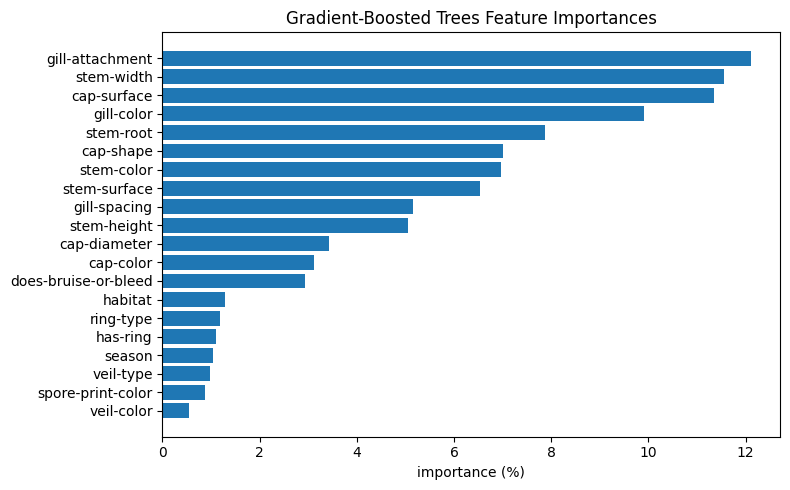

In [47]:
# Feature importances
gbt_items = tree_feature_importance(gbt_fitted, top_m=20, plot=True, title="Gradient-Boosted Trees Feature Importances")

**!Conclusion:**
The GBT model relies most on gill-related attributes (especially gill-attachment and gill-color), along with key size/surface features such as stem-width and cap-surface. Overall, gill and stem characteristics dominate the boosted model’s decisions, while features like veil-color and spore-print-color contribute relatively little.

#### 8.3.3. Predicting on the Test Set

After training the GBT pipeline, I generate predictions on the held-out test set using `transform()`. I then evaluate performance using Spark’s evaluators (accuracy and F1-score). For reproducibility and interpretation, I also print the main trained hyperparameters—`maxDepth`, `maxIter`, and `stepSize`—to document the final GBT configuration used in this run.

For a quick overfitting check, I also compute the **training accuracy** using the same evaluator and compare it with the test result.


In [48]:
# Predict on held-out test set ---
gbt_pred = gbt_fitted.transform(test_df)

# Metrics (accuracy + F1) ---
acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

acc_gbt = acc_eval.evaluate(gbt_pred)
f1_gbt  = f1_eval.evaluate(gbt_pred)

# Access trained model hyperparams
tree_model = gbt_fitted.stages[-1]

print(f"maxDepth: {tree_model.getMaxDepth()}")
print(f"maxIter: {tree_model.getMaxIter()}")
print(f"stepSize: {tree_model.getStepSize()}")

print(f"Test Accuracy : {acc_gbt * 100:.3f}%")
print(f"Test F1-score  : {f1_gbt:.5f}")

maxDepth: 8
maxIter: 100
stepSize: 0.1
Test Accuracy : 99.975%
Test F1-score  : 0.99975


In [49]:
# Train accuracy
gbt_pred_train = gbt_fitted.transform(train_df)
acc_gbt_train = acc_eval.evaluate(gbt_pred_train)
print(f"Train accuracy: {round(acc_gbt_train * 100, 3)}%")

Train accuracy: 99.986%


**!Conclusion:**
The GBT model achieves near-perfect performance on the test set (≈99.98% accuracy, F1 ≈0.9998). The training and test accuracies are almost identical, which suggests excellent generalization with no clear signs of overfitting for this configuration.

#### 8.3.4. Confusion Matrix

To complement the evaluation metrics, I plot a **confusion matrix** for the GBT predictions. This visualization summarizes correct classifications and highlights the types of errors (false positives vs. false negatives) for edible and poisonous mushrooms, providing a clearer view of model behavior beyond overall accuracy.


Accuracy : 99.975%
F1-score  : 0.99975
Precision : 0.99985
Recall    : 0.99970



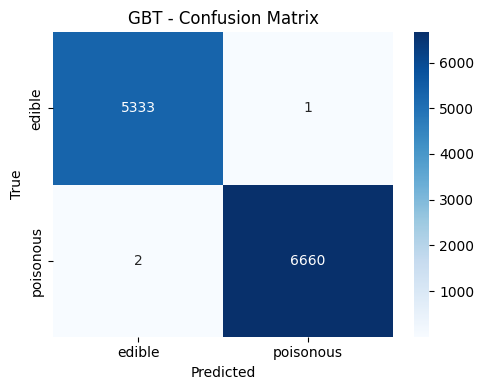

In [50]:
# Confusion matrix plot
gbt_cm = plot_confusion_matrix(gbt_pred, title="GBT - Confusion Matrix")

**!Conclusion:**
The GBT classifier achieves almost perfect performance, with only three total misclassifications on the test set. The confusion matrix confirms that both edible and poisonous mushrooms are predicted with extremely high precision and recall.

#### 8.3.5. PCA Visualization (2D Projection)

In this step, I use **Spark PCA** to project the high-dimensional feature vector into two components (`k=2`) to obtain a 2D representation of the test samples. This projection is used only for visualization (it does not affect training). After transforming the GBT predictions with PCA, I mark each sample as **correct** or **incorrect** based on whether the predicted label matches the true label, and then plot the two PCA components in a scatter plot. This provides an intuitive view of how well the classes separate in a low-dimensional space and where the model’s mistakes tend to occur.


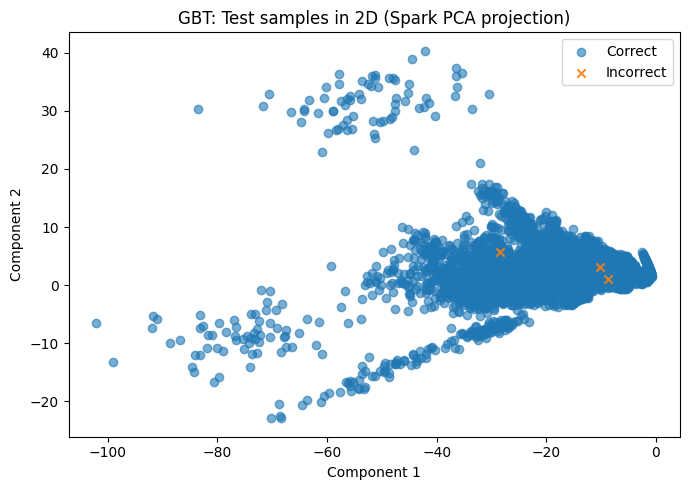

In [60]:
from pyspark.ml.feature import PCA

# 2) Fit PCA (k=2) on the features (you can fit on train for consistency; test is OK for visualization)
pca = PCA(k=2, inputCol="features", outputCol="pca2")
pca_model = pca.fit(gbt_pred)
gbt_2d = pca_model.transform(gbt_pred)

# 3) Mark correct vs incorrect
gbt_2d = gbt_2d.withColumn("correct", (F.col("prediction") == F.col("label")).cast("int"))

# 4) Collect only what we need (limit for speed)
rows = gbt_2d.select("pca2", "correct").limit(20000).collect()

X = np.array([r["pca2"].toArray() for r in rows])
correct = np.array([r["correct"] == 1 for r in rows])

# 5) Plot
plt.figure(figsize=(7, 5))
plt.scatter(X[correct, 0], X[correct, 1], alpha=0.6, marker="o", label="Correct")
plt.scatter(X[~correct, 0], X[~correct, 1], alpha=0.9, marker="x", label="Incorrect")
plt.title("GBT: Test samples in 2D (Spark PCA projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.tight_layout()
plt.show()

**!Conclusion:**
The 2D PCA projection shows that most test samples form clear clusters, and the GBT model classifies nearly all of them correctly. The few misclassified points appear near denser, overlapping regions in the projection, suggesting the remaining errors occur on borderline cases that are less separable in low-dimensional space.

In [51]:
# Adding the Gradient-Boosted Trees Results to the all_models list
gbt_results = {"model": 'Gradient Boosted Tree', "test_acc": round(acc_gbt * 100, 3), "test_f1": round(f1_gbt, 5)}
all_models.append(gbt_results)

In [52]:
all_models

[{'model': 'Decision Tree', 'test_acc': 99.792, 'test_f1': 0.99792},
 {'model': 'Random Forest', 'test_acc': 99.25, 'test_f1': 0.9925},
 {'model': 'Gradient Boosted Tree', 'test_acc': 99.975, 'test_f1': 0.99975}]

## 9. Final Conclusion (Model Comparison)

In this final section, I summarize the results of all trained models. First, I print a compact comparison table containing each classifier’s **test accuracy** and **test F1-score**. Then, I visualize these metrics using side-by-side bar charts to make performance differences easier to interpret at a glance. This final comparison helps me identify which model provides the best overall predictive performance on the held-out test set.


In [72]:
print_all_models_table(all_models)

Model                  Test Accuracy (%)  Test F1
-------------------------------------------------
Decision Tree                     99.792  0.99792
Random Forest                     99.250  0.99250
Gradient Boosted Tree             99.975  0.99975


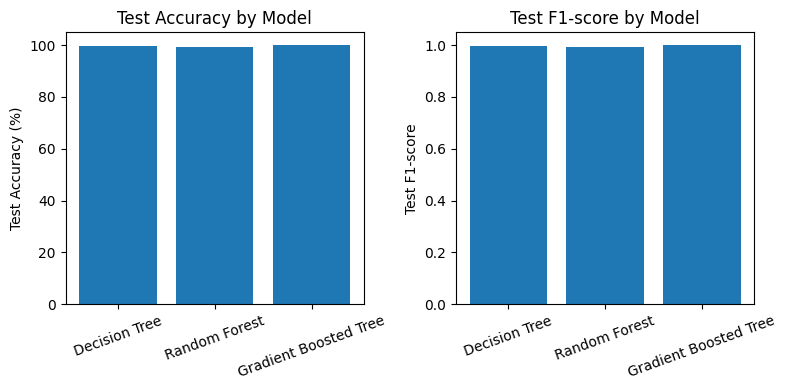

In [54]:
# ---- Prepare arrays for plotting ----
models = [row["model"] for row in all_models]
accs   = [row["test_acc"] for row in all_models]   # already in %
f1s    = [row["test_f1"] for row in all_models]

# ---- Plot ----
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Accuracy plot
axes[0].bar(models, accs)
axes[0].set_title("Test Accuracy by Model")
axes[0].set_ylabel("Test Accuracy (%)")
axes[0].tick_params(axis="x", rotation=20)

# F1 plot
axes[1].bar(models, f1s)
axes[1].set_title("Test F1-score by Model")
axes[1].set_ylabel("Test F1-score")
axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

**!Final Conclusion:**

Based on the held-out test results, all three tree-based classifiers perform extremely well, with accuracy above 99% and F1-scores above 0.99. The Gradient-Boosted Tree achieves the best overall performance (99.975% accuracy, 0.99975 F1), followed by the Decision Tree (99.792%, 0.99792). The Random Forest is slightly lower (99.250%, 0.99250) but still highly accurate. Overall, GBT is the strongest choice in this comparison, offering the most reliable predictive performance on this dataset.